In [1]:
import sys
!{sys.executable} -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [103]:
## Importing Libraries
import re
import numpy as np
import pandas as pd

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [104]:
# More Imports
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [105]:
%matplotlib inline

warnings.filterwarnings("ignore",category=DeprecationWarning)

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [106]:
# NLTK Stop words

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 
                   'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 
                   'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 
                   'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 
                   'need', 'even', 'right', 'line', 'even', 'also', 'may', 
                   'take', 'come', 'http','https','www','com','@','...','…', 'var', 
                   'ref', 'document', 'referrer', 'var', 'bbpath', 'href', 'archive', 
                   'function', 'beige','book', 'federal', 'reserve', 'summary', 
                   'indexof', 'backtoresults','history', 'go', 'else', 'window', 
                   'location', 'back', 'search','this', 'report', 'prepared', 'federal', 
                   'reserve', 'bank', 'summarizes','january', 'february', 'march', 'april', 
                   'may', 'june', 'july', 'august','september', 'october', 'november', 
                   'december', 'atlanta', 'boston', 'chicago','cleveland', 'dallas', 
                   'kansas', 'minneapolis', 'york', 'philadelphia', 'richmond', 'san', 
                   'francisco', 'st', 'louis', 'officials', 'comments', 
                   'views', 'commentary', 'national', 'based', 'information', 'collected',
                   'received', 'contacts', 'outside', 'system', 'page', 'url', 'link', 
                   'district', 'districts', 'activity',
                  ])

We include additional "stopwords". Due to the repetitive format of these documents, we exclude the words above to remove any irrelavant words from influencing the analysis.

## Importing The Beige Book (District) Dataset

In [107]:
## import the data 
## The data directory is hidden due to its size.
## These files will be made available upon request.
df = pd.read_csv('./data/beige_book_district.csv')
df.head()

,district_report,date,district
0,\n\r\n var ref = document.referrer;\r\n var bBPath = 'beige-book-archive';\r\n function...,2019-04,at
1,\n\r\n var ref = document.referrer;\r\n var bBPath = 'beige-book-archive';\r\n function...,2019-03,at
2,\n\r\n var ref = document.referrer;\r\n var bBPath = 'beige-book-archive';\r\n function...,2019-01,at
3,\n\r\n var ref = document.referrer;\r\n var bBPath = 'beige-book-archive';\r\n function...,2018-12,at
4,\n\r\n var ref = document.referrer;\r\n var bBPath = 'beige-book-archive';\r\n function...,2018-10,at


## Tokenize Sentences and Clean

In [108]:
## function that removes special characters, 
## and splits each sentence into a list of words using gensim’s simple_preprocess()

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert dataframe to a list
data = df['district_report'].values.tolist()
data_words = list(sent_to_words(data))
#print(data_words[:1])


## Build the Bigram, Trigram Models and Lemmatize

In [109]:
## Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [ ]:
# !python3 -m spacy download en  # run in terminal once

In [110]:
# lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build a Topic Model

In [111]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [112]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=20190511,
                                           update_every=1,
                                           chunksize=50,
                                           passes=10,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)

In [113]:
pprint(lda_model.print_topics())

[(0,
  '0.020*"percent" + 0.019*"sale" + 0.019*"year" + 0.018*"construction" + '
  '0.017*"area" + 0.014*"crop" + 0.012*"recent" + 0.011*"industry" + '
  '0.010*"strong" + 0.010*"rate"'),
 (1,
  '0.022*"increase" + 0.022*"price" + 0.022*"demand" + 0.018*"sale" + '
  '0.017*"estate" + 0.017*"continue" + 0.016*"remain" + 0.015*"real" + '
  '0.015*"service" + 0.015*"growth"'),
 (2,
  '0.036*"percent" + 0.031*"sale" + 0.028*"loan" + 0.027*"year" + '
  '0.022*"increase" + 0.020*"month" + 0.016*"level" + 0.016*"rate" + '
  '0.014*"continue" + 0.013*"expect"'),
 (3,
  '0.017*"demand" + 0.015*"business" + 0.015*"price" + 0.012*"rate" + '
  '0.011*"saving" + 0.011*"high" + 0.011*"firm" + 0.010*"inventory" + '
  '0.009*"interest" + 0.009*"large"')]


The weights on each word captures the importance of each keyword in the document.

## Dominant topic and its percentage contribution in each document

In [114]:
## a function that extracts the dominant topic for each sentence 
# and shows the weight of the topic and the keywords in a dataframe

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [115]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Formatting the dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7144,"increase, price, demand, sale, estate, continue, remain, real, service, growth","[economic, sixth, business, indicate, economic, condition, improve, modest, pace, previous, majo..."
1,1,1.0,0.7294,"increase, price, demand, sale, estate, continue, remain, real, service, growth","[economic, sixth, business, economic, continued, advance, moderate, pace, period, outlook, remai..."
2,2,1.0,0.7207,"increase, price, demand, sale, estate, continue, remain, real, service, growth","[economic, sixth, business, remain, largely, positive, majority, note, economic, grow, moderate,..."
3,3,1.0,0.6921,"increase, price, demand, sale, estate, continue, remain, real, service, growth","[economic, sixth, business, describe, economic, condition, expand, moderate, pace, previous, maj..."
4,4,1.0,0.6811,"increase, price, demand, sale, estate, continue, remain, real, service, growth","[economic, sixth, business, indicate, economic, expand, moderate, pace, mid, expect, pace, conti..."


In [116]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
5143,5143,0.0,0.4259,"percent, sale, year, construction, area, crop, recent, industry, strong, rate","[scatter, sign, improvement, economic, condition, apparent, eighth, pessimism, still, prevail, m..."
5144,5144,3.0,0.3670,"demand, business, price, rate, saving, high, firm, inventory, interest, large","[expectation, early, upturn, business, eighth, dampen, recent, week, increase, amount, skepticis..."
5145,5145,3.0,0.5381,"demand, business, price, rate, saving, high, firm, inventory, interest, large","[dampen, optimism, recent, week, regard, business, outlook, eighth, director, branch, businessma..."
5146,5146,3.0,0.4734,"demand, business, price, rate, saving, high, firm, inventory, interest, large","[discussion, branch, main, office, board, director, large, business, firm, financial, editor, co..."
5147,5147,3.0,0.6105,"demand, business, price, rate, saving, high, firm, inventory, interest, large","[select, group, knowledgeable, person, eighth, include, director, head, office, louisville, bran..."


In [117]:
set(df_dominant_topic['Dominant_Topic'])

{0.0, 1.0, 2.0, 3.0}

In [118]:
df_dominant_topic['Keywords'][0]

'increase, price, demand, sale, estate, continue, remain, real, service, growth'

In [119]:
df_dominant_topic['Keywords'][428]

'percent, sale, year, construction, area, crop, recent, industry, strong, rate'

## The most representative sentence for each topic

In [120]:
# Display setting to show more characters in column.
pd.options.display.max_colwidth = 100

# Get samples of sentences that most represent a given topic.
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8460,"percent, sale, year, construction, area, crop, recent, industry, strong, rate","[general, economic, expand, rapidly, businessman, optimistic, term, outlook, pickup, plan, comme..."
1,1.0,0.9049,"increase, price, demand, sale, estate, continue, remain, real, service, growth","[twelfth, economy, expand, solid, pace, late, inflation, reportedly, well, contain, frequently, ..."
2,2.0,0.8620,"percent, sale, loan, year, increase, month, level, rate, continue, expect","[economic, condition, third, generally, stable, indication, improvement, sector, manufacture, ma..."
3,3.0,0.8381,"demand, business, price, rate, saving, high, firm, inventory, interest, large","[president_nixon, shift, economic, policy, well, director, banker, businessman, third, however, ..."


In [121]:
sent_topics_sorteddf_mallet['Keywords'][0]

'percent, sale, year, construction, area, crop, recent, industry, strong, rate'

In [122]:
sent_topics_sorteddf_mallet['Keywords'][2]

'percent, sale, loan, year, increase, month, level, rate, continue, expect'

In [123]:
sent_topics_sorteddf_mallet['Keywords'][1]

'increase, price, demand, sale, estate, continue, remain, real, service, growth'

In [124]:
sent_topics_sorteddf_mallet['Keywords'][3]

'demand, business, price, rate, saving, high, firm, inventory, interest, large'

## Frequency Distribution of Word Counts in Documents

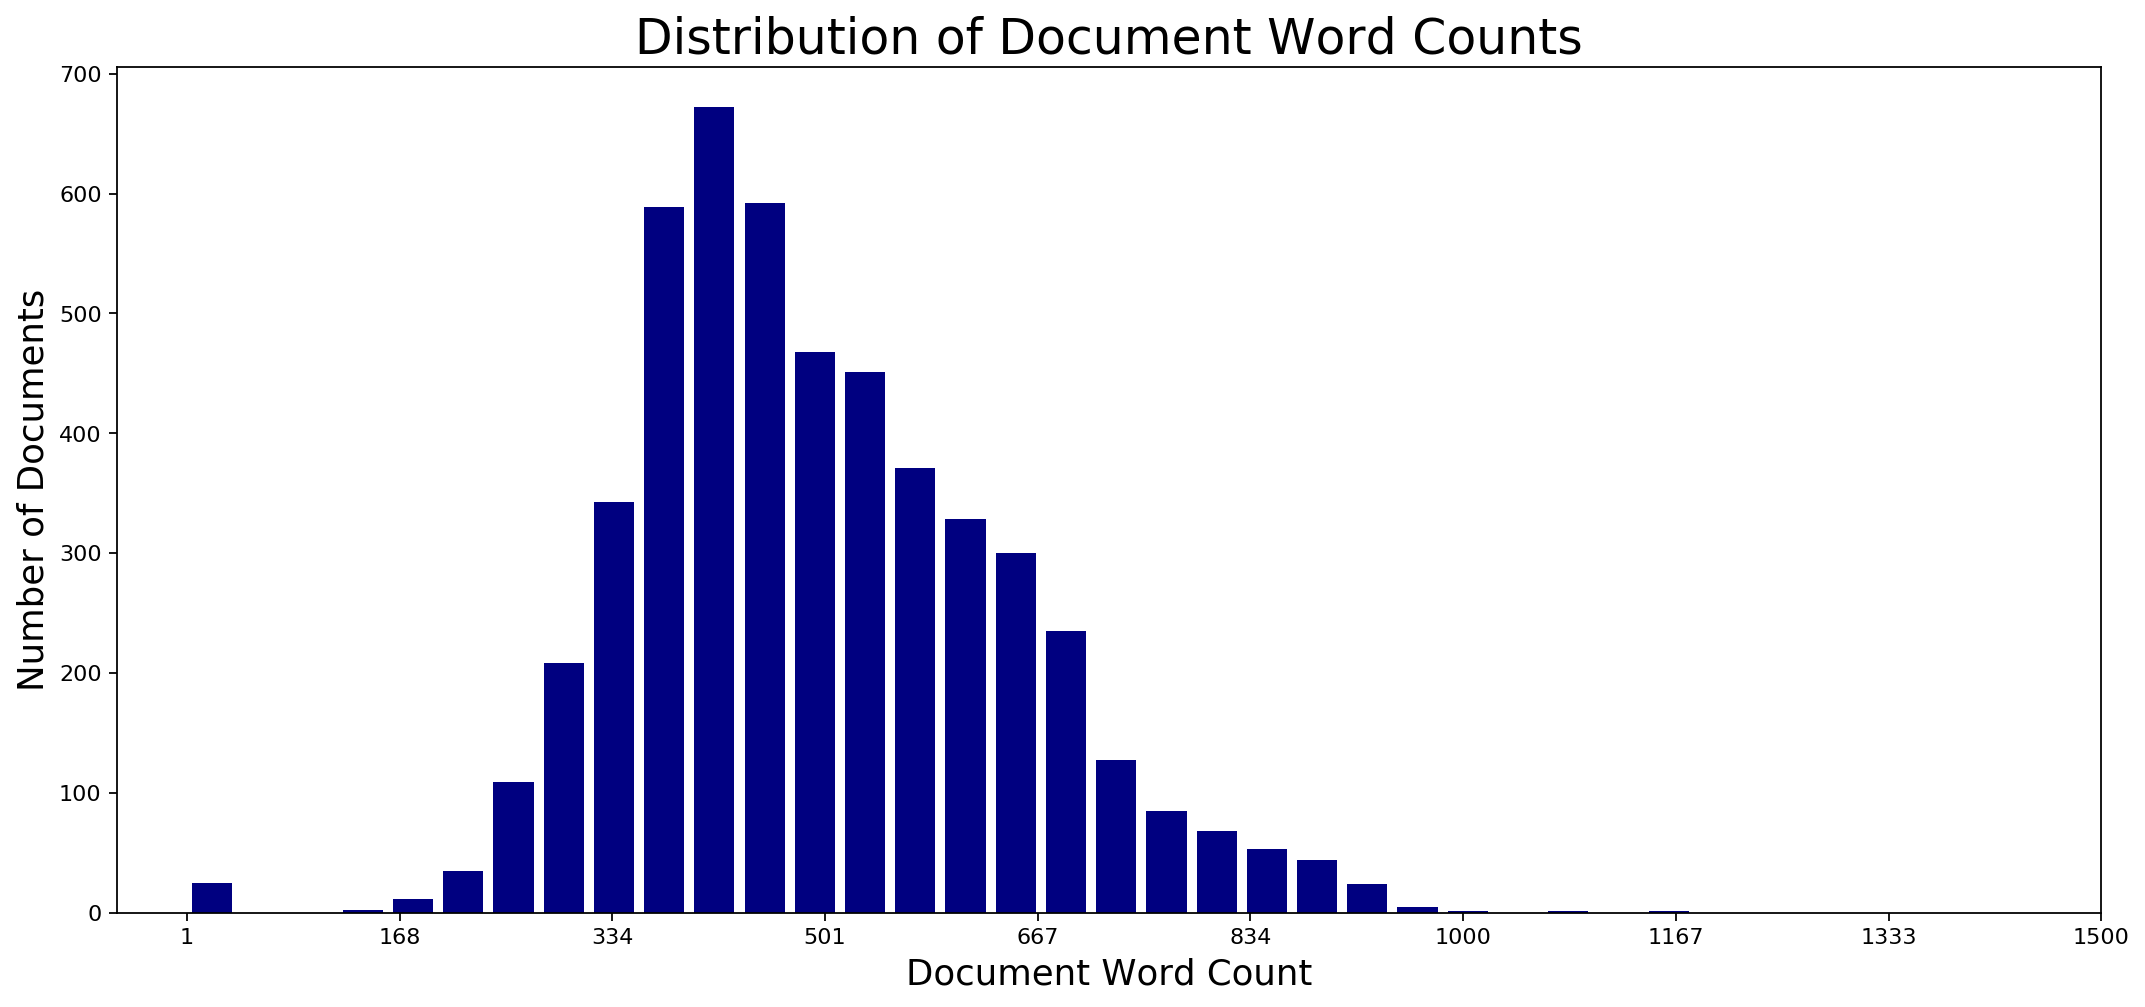

In [125]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot a frequency distribution of word counts.
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins=30, color='navy', rwidth=0.8)
# plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

#plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.ylabel('Number of Documents', fontsize=16)
plt.xlabel('Document Word Count', fontsize=16)
#plt.tick_params(size=10)
plt.xticks(np.linspace(1,1500,10))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('./Images/Distribution_count.png')
plt.show();

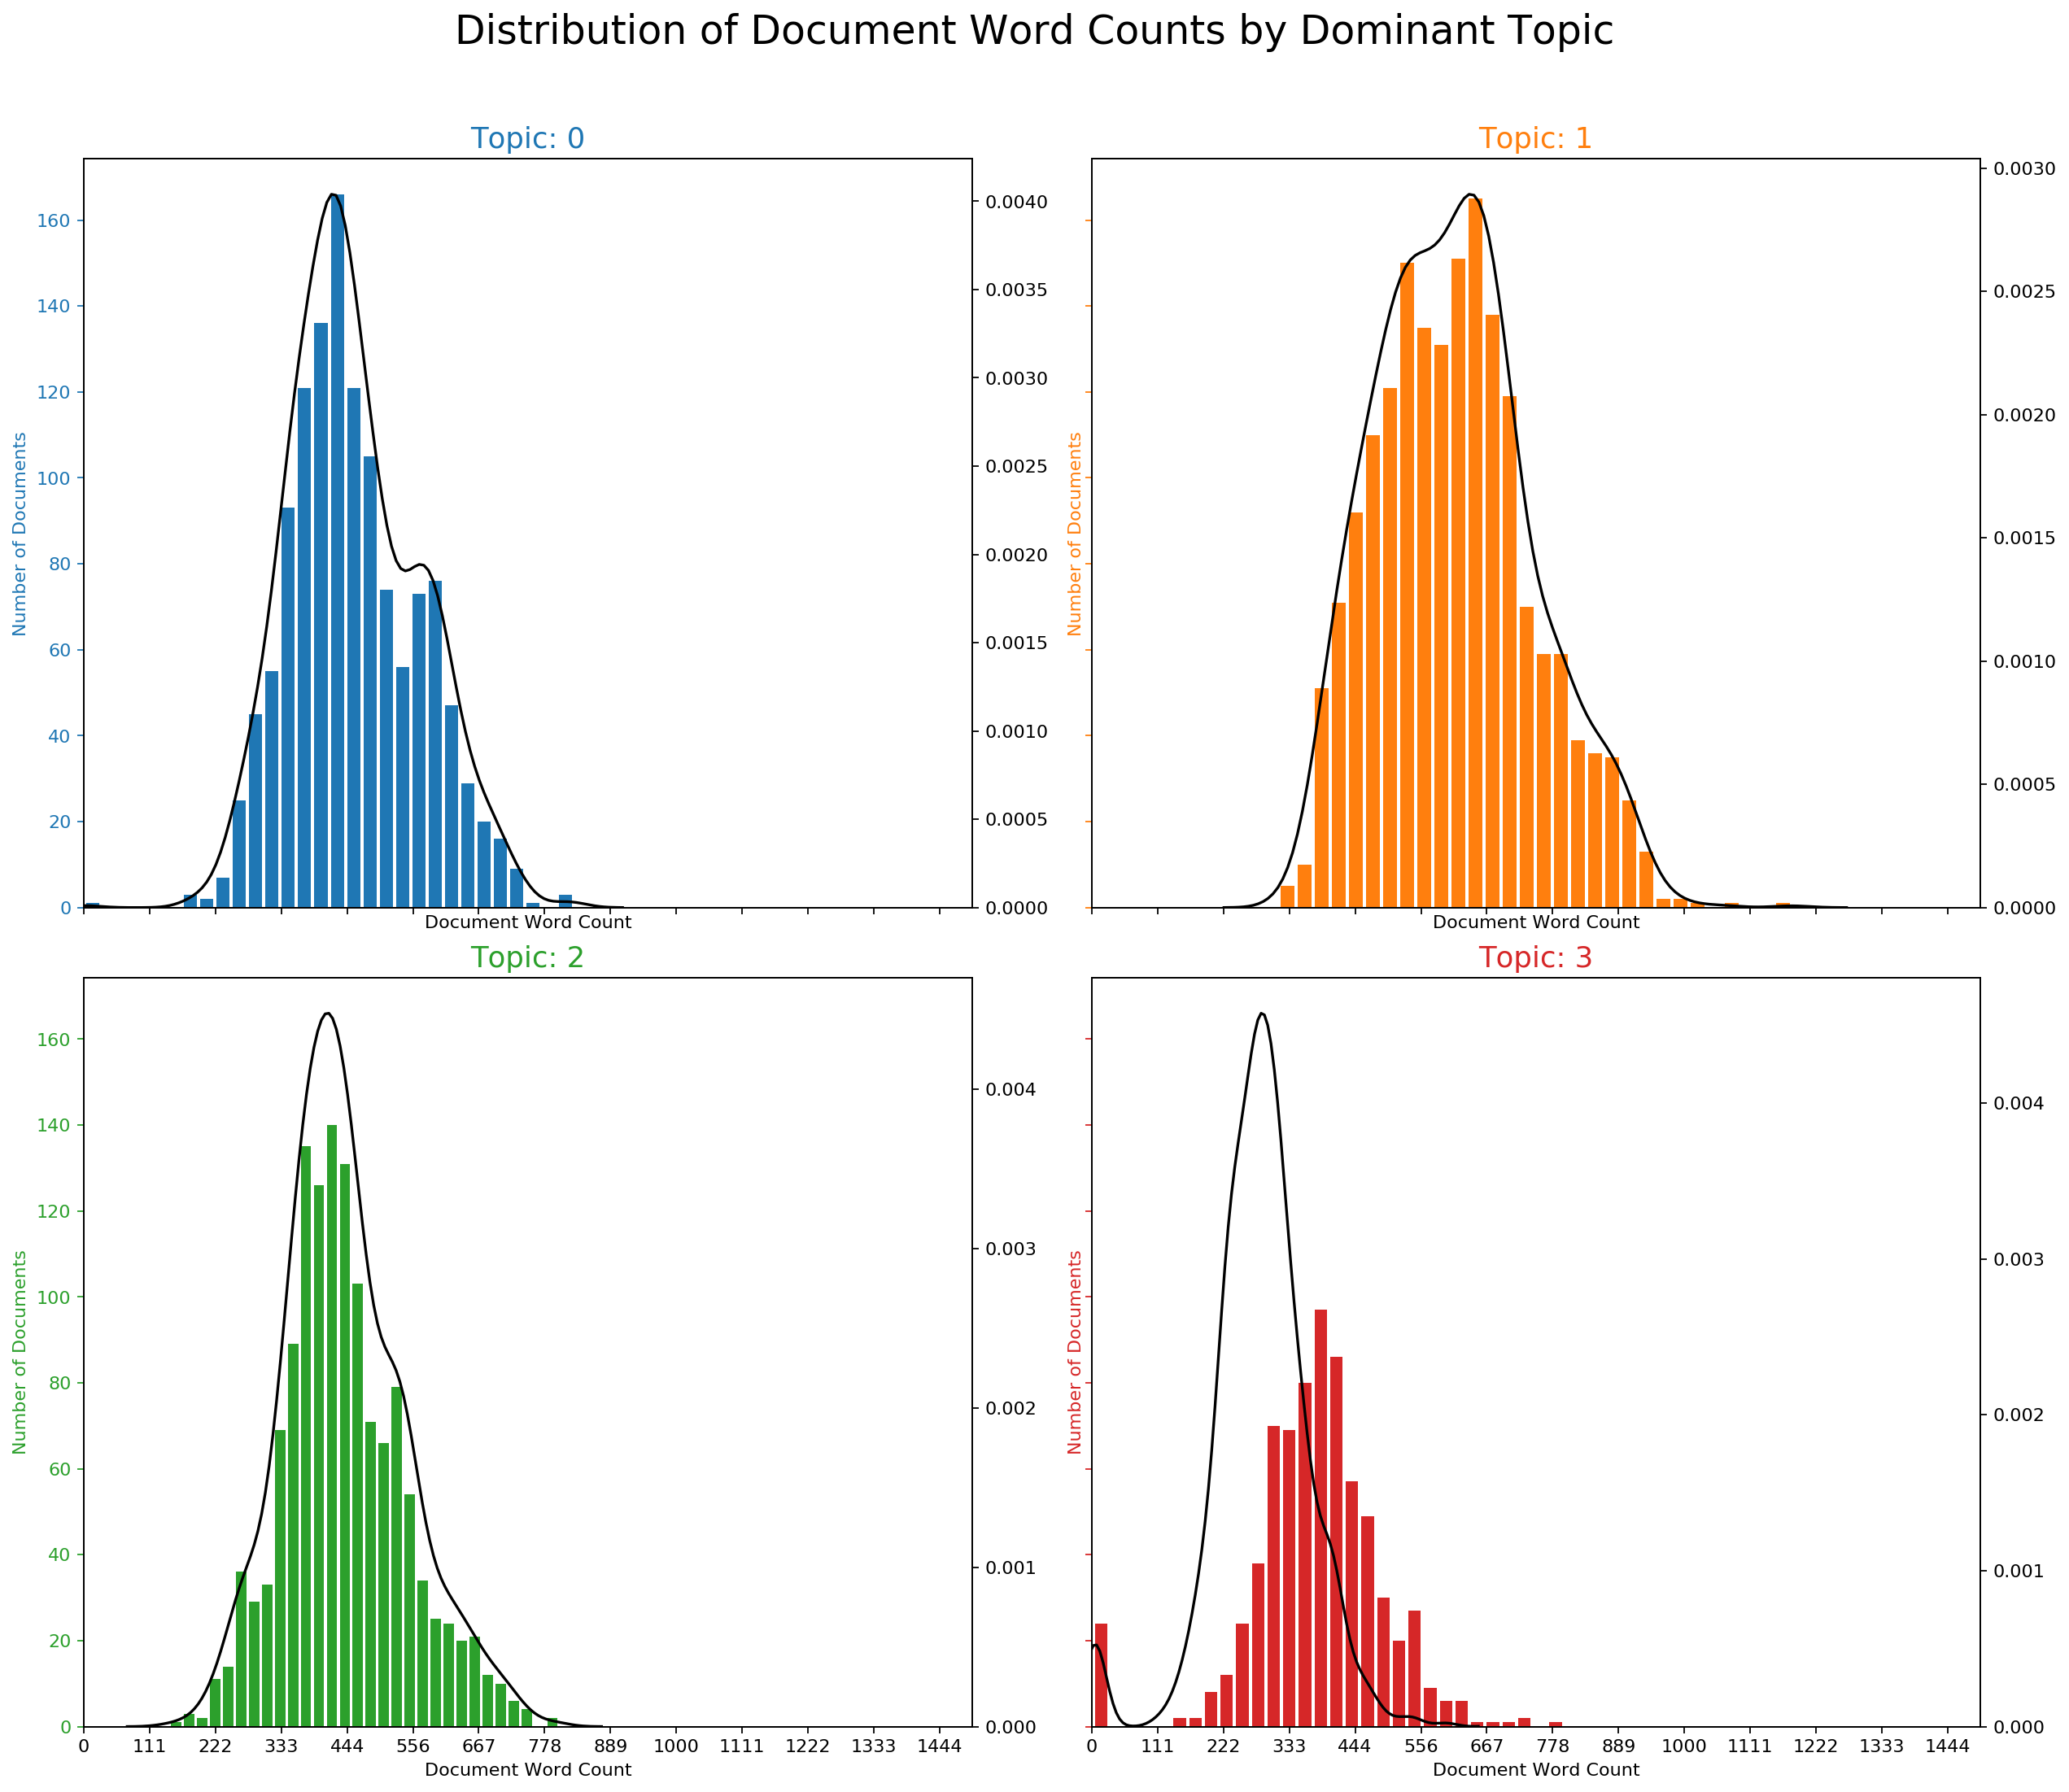

In [126]:
# Plots the distribution of document word counts by dominant topic.
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2, figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 30, color=cols[i], rwidth=0.8)
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1500), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,2000,19))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Clouds of Top N Keywords in Each Topic

In [127]:
# if n % 2 != 0:
#     for l in axs[i/2-1,1].get_xaxis().get_majorticklabels():
#         l.set_visible(True)
#     f.delaxes(axs[i/2, 1])

# f.show()

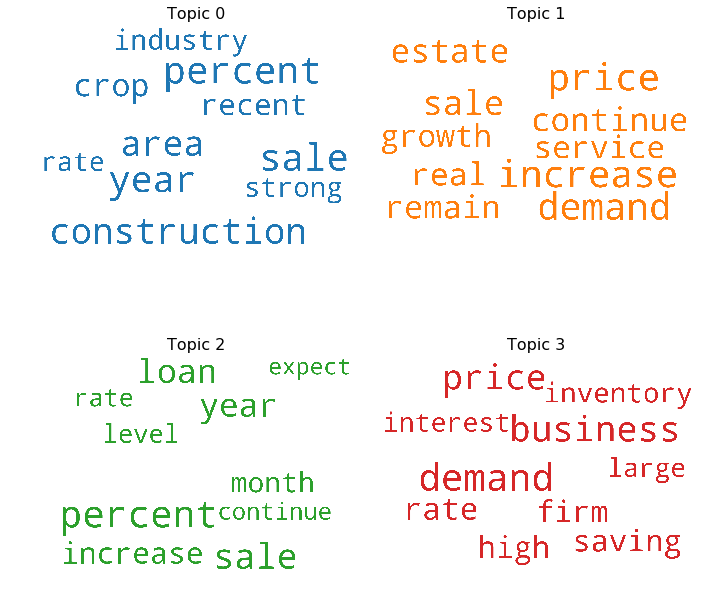

In [128]:
# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

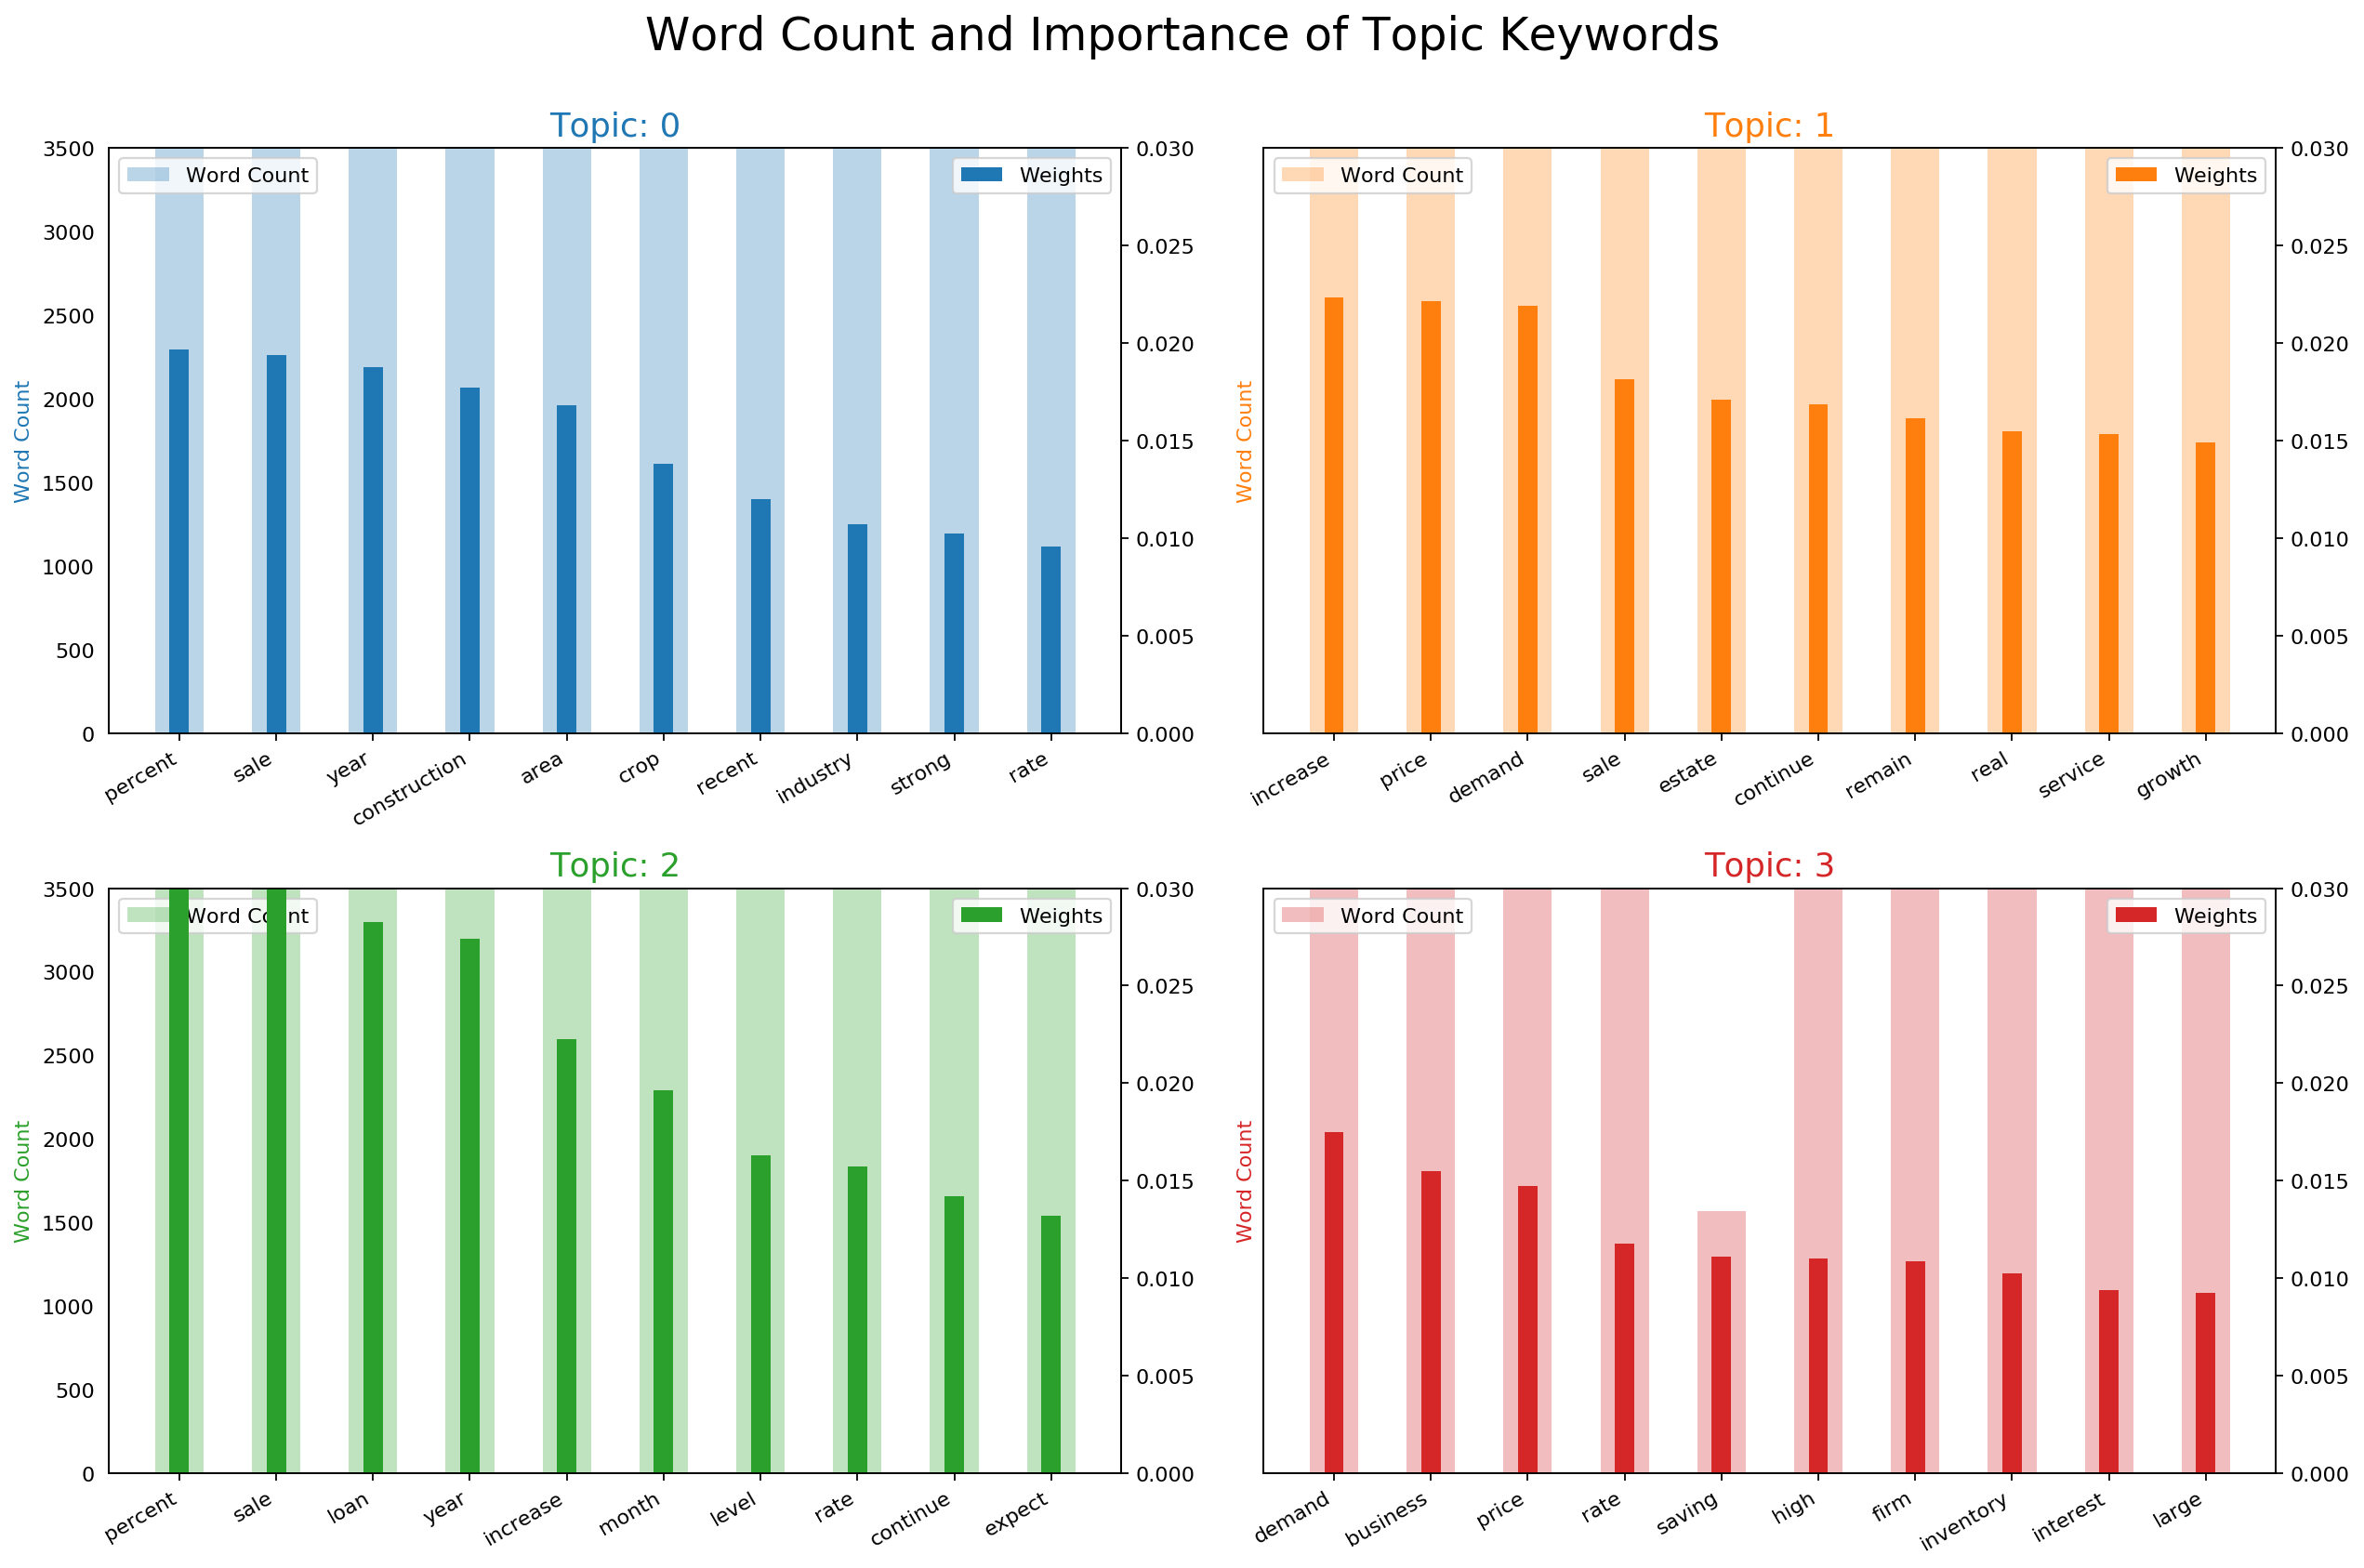

In [129]:
## 
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The above barcharts displays the word count and importance (weights) of topic keywords. Words that occur in more than one topic and those whose relative frequency is greater than its weights often tend to be less important. The first time we ran this anumber of words showed up in multiple topics but were not very important. We took these words out (for instance "activity") and added to the list of stopwords and re-ran the model.

## Sentence Chart Colored by Topic

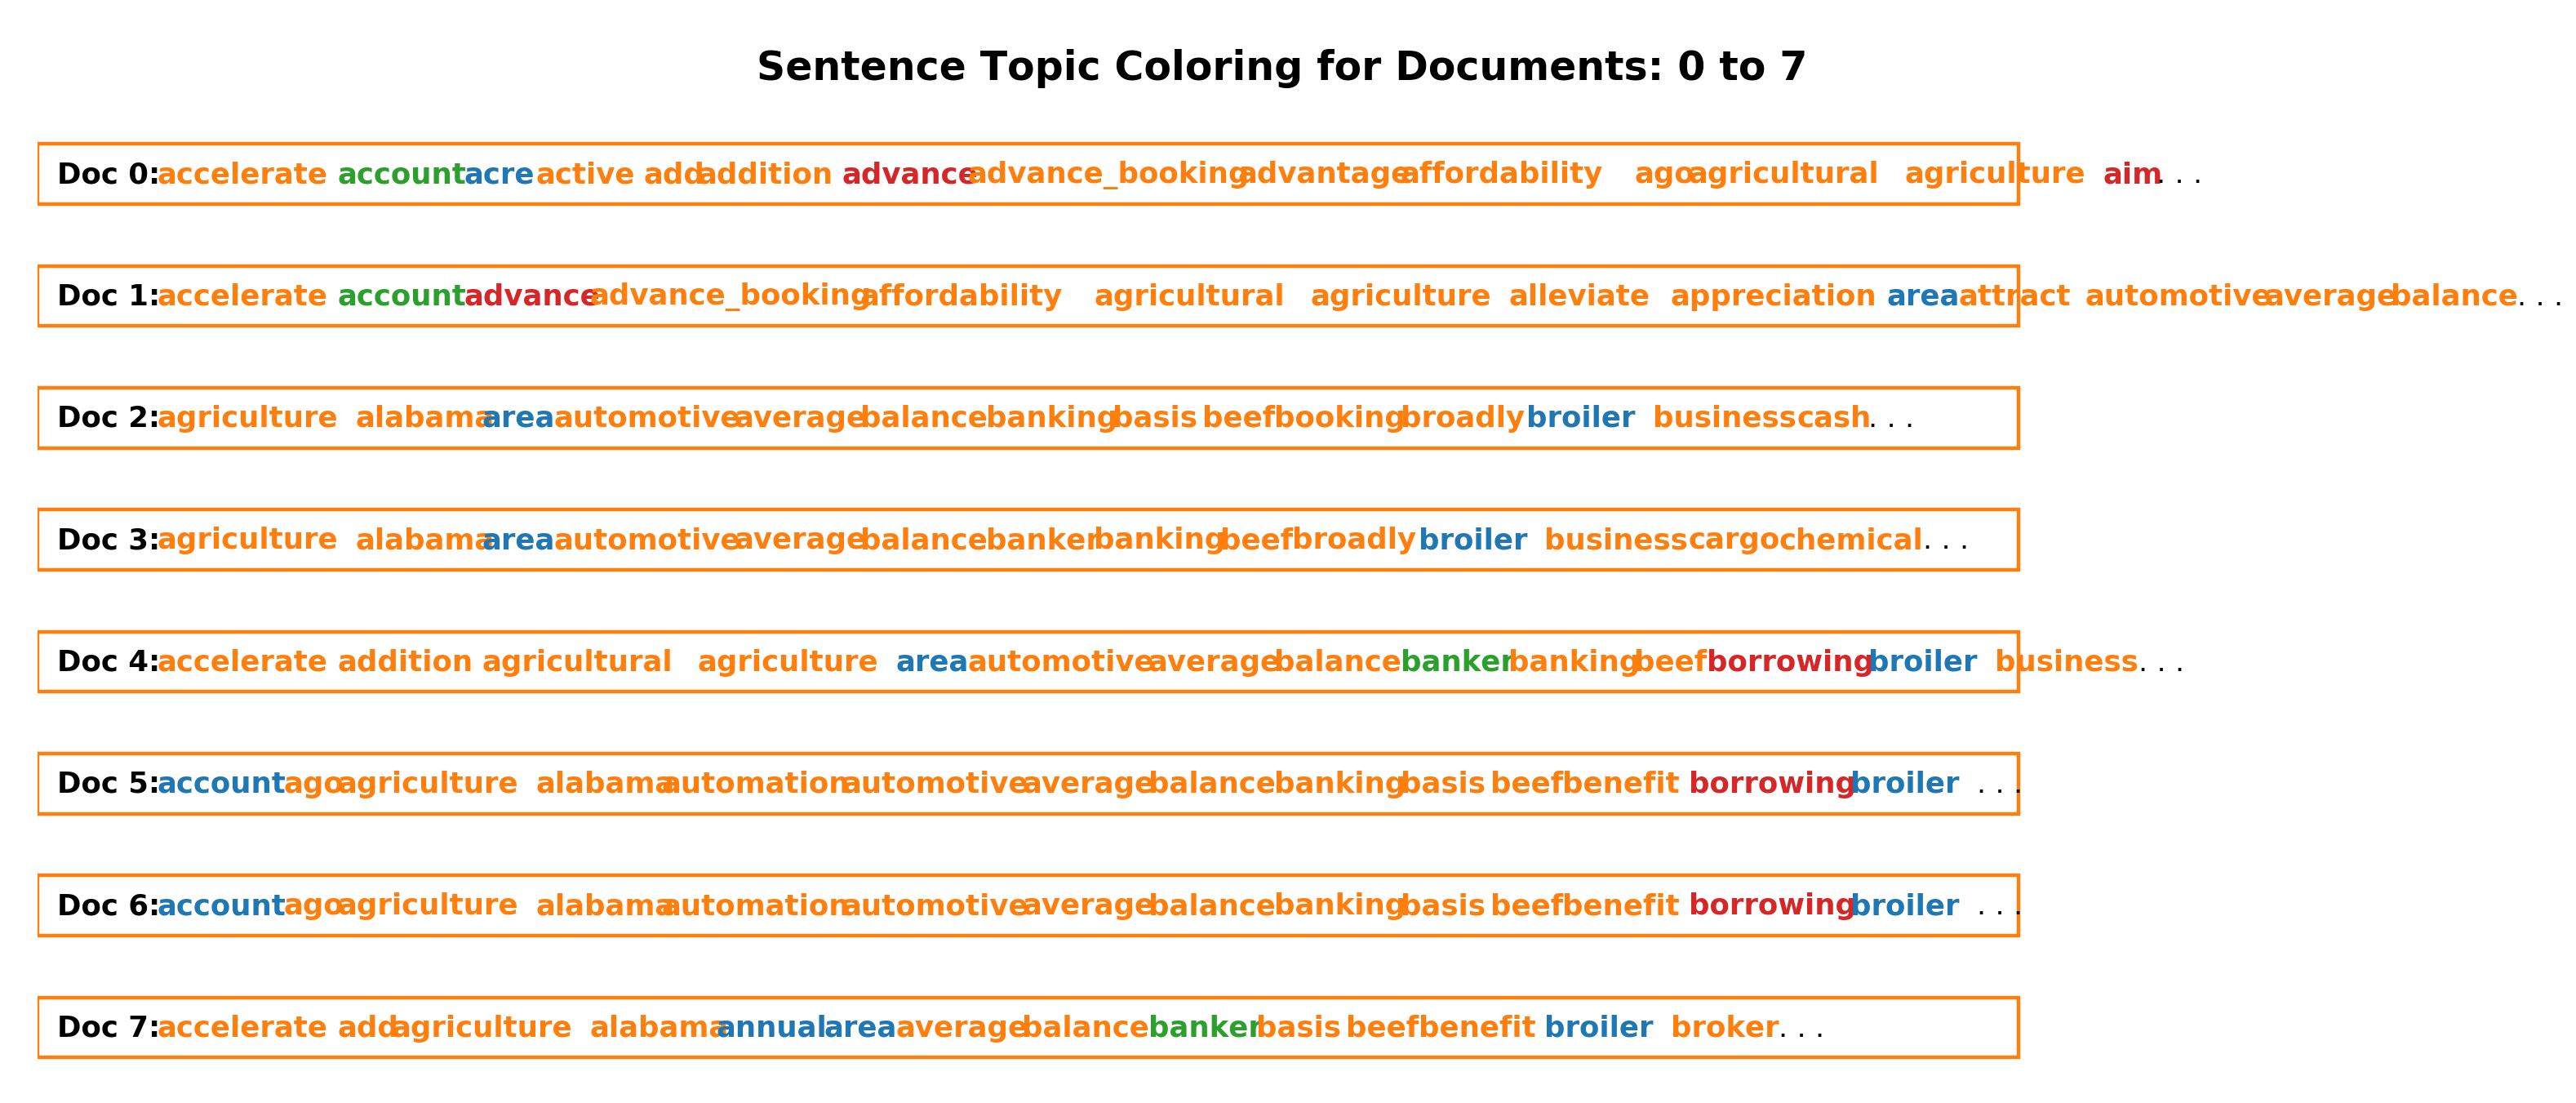

In [130]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 9):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

Each word in the each document is representative of one of the 4 topics. The above graph shows us which words are most dominant, and which topic they represent, in the first 8 documents. For example, topic 2 appears to be the most dominant topic in the first 8 documents. Hence, these 8 documents are most representative of topic 2. 

## The most discussed topics in the documents

In [131]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

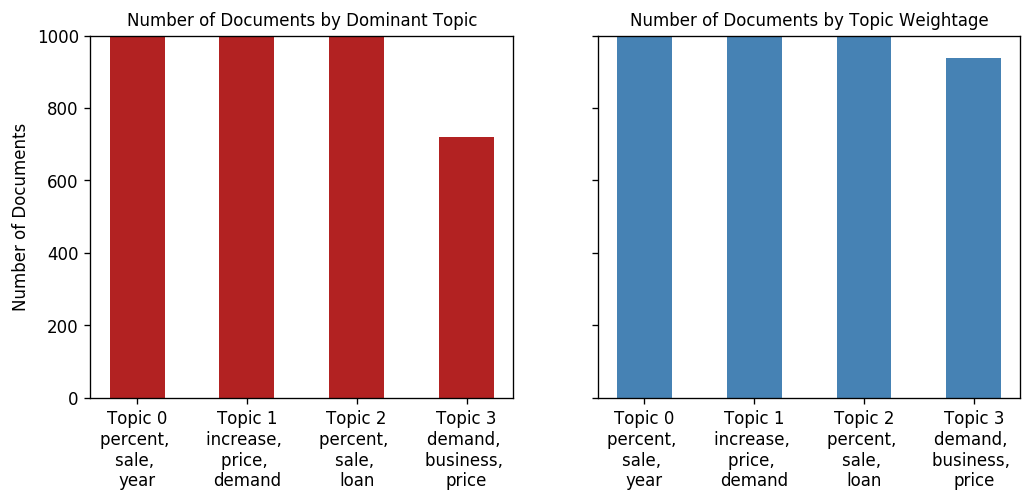

In [132]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

The graphs above show:
- The number of documents for each topic.
    - We observe that the first three topics are represented by at least 1,000 documents.
    - The fourth topic, on the other hand, is represented by at about 700 documents.

- The number of documents for each topic by weights.

## t-distributed stochastic neighbor embedding (tSNE) Clustering Chart

[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [85]:
# imports
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [133]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

In [134]:
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

In [88]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=20190511, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4967 samples in 0.005s...
[t-SNE] Computed neighbors for 4967 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4967
[t-SNE] Computed conditional probabilities for sample 2000 / 4967
[t-SNE] Computed conditional probabilities for sample 3000 / 4967
[t-SNE] Computed conditional probabilities for sample 4000 / 4967
[t-SNE] Computed conditional probabilities for sample 4967 / 4967
[t-SNE] Mean sigma: 0.035944
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.767380
[t-SNE] KL divergence after 1000 iterations: 0.942235


Loading BokehJS ...

In [136]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=20190511, angle=.99, init='pca', 
                  perplexity=70.0,n_iter=3000)

tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 4967 samples in 0.001s...
[t-SNE] Computed neighbors for 4967 samples in 0.202s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4967
[t-SNE] Computed conditional probabilities for sample 2000 / 4967
[t-SNE] Computed conditional probabilities for sample 3000 / 4967
[t-SNE] Computed conditional probabilities for sample 4000 / 4967
[t-SNE] Computed conditional probabilities for sample 4967 / 4967
[t-SNE] Mean sigma: 0.050723
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.909157
[t-SNE] KL divergence after 3000 iterations: 0.766730


Loading BokehJS ...

So the t-SNE algorithm works like this:
- The t-distribution is used to produce a joint probability distribution that describes the closeness of high dimensional points.
- A second set of low dimensional data points (to correspond to each high dimensional data point) is randomly initialised and the t-distribution is used to create another joint probability distribution.
- Gradient descent is used to minimise the divergence between the two distributions by updating the values of the low dimensional data points.

We find that even after tuning, by changing the perplexity (from 30, 50, and then 70), the clusters do not change. In all plots, we see  tight and slightly separated clusters. This possibly suggests that, although we are able to identify four topics in these documents, the vocabulary of these documents are very similar. This we beleive is demonstrated by the tSNE plot.  

## pyLDAVis

In [ ]:
#!pip install pyLDAvis

In [89]:
import pyLDAvis.gensim

In [90]:
pyLDAvis.enable_notebook()

In [91]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.057643 -0.143694       1        1  34.489094
0     -0.093423  0.145772       2        1  24.977680
2     -0.104271 -0.016312       3        1  24.554762
3      0.255337  0.014235       4        1  15.978461, topic_info=     Category          Freq          Term         Total  loglift  logprob
226   Default  35139.000000       percent  35139.000000  30.0000  30.0000
458   Default  13470.000000       service  13470.000000  29.0000  29.0000
366   Default  36421.000000          year  36421.000000  28.0000  28.0000
100   Default  16653.000000        estate  16653.000000  27.0000  27.0000
393   Default   9264.000000          crop   9264.000000  26.0000  26.0000
284   Default  47942.000000          sale  47942.000000  25.0000  25.0000
178   Default  27990.000000          loan  27990.000000  24.0000  24.0000
258   Default  17147.000000          real  17147.000000  23.0000  23.0000
199   Default  16730.000000         month  16730.000000  22.0000  22.0000
72    Default  30834.000000        demand  30834.000000  21.0000  21.0000
58    Default  23441.000000  construction  23441.000000  20.0000  20.0000
827   Default   4521.000000        saving   4521.000000  19.0000  19.0000
20    Default  16804.000000          area  16804.000000  18.0000  18.0000
39    Default  18309.000000      business  18309.000000  17.0000  17.0000
121   Default  18684.000000          firm  18684.000000  16.0000  16.0000
357   Default   8427.000000          wage   8427.000000  15.0000  15.0000
255   Default   6865.000000       quarter   6865.000000  14.0000  14.0000
242   Default  31777.000000         price  31777.000000  13.0000  13.0000
327   Default   7671.000000        survey   7671.000000  12.0000  12.0000
170   Default  10928.000000         large  10928.000000  11.0000  11.0000
211   Default  14066.000000          note  14066.000000  10.0000  10.0000
175   Default  19464.000000         level  19464.000000   9.0000   9.0000
136   Default  16736.000000        growth  16736.000000   8.0000   8.0000
63    Default   7729.000000          cost   7729.000000   7.0000   7.0000
248   Default  10676.000000       product  10676.000000   6.0000   6.0000
609   Default   4413.000000       capital   4413.000000   5.0000   5.0000
163   Default   6177.000000      interest   6177.000000   4.0000   4.0000
70    Default  15379.000000       decline  15379.000000   3.0000   3.0000
4959  Default   3792.000000        eighth   3792.000000   2.0000   2.0000
51    Default  17273.000000    commercial  17273.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
1379   Topic4    889.538391     excessive   1075.582764   1.6440  -6.1263
163    Topic4   3822.739014      interest   6177.137695   1.3540  -4.6683
500    Topic4   2613.525635       concern   4154.428223   1.3705  -5.0485
604    Topic4   1203.047363       believe   1620.823975   1.5359  -5.8244
719    Topic4   2704.573730       current   4470.746582   1.3313  -5.0143
2005   Topic4   1655.266602   association   2420.254395   1.4540  -5.5053
1215   Topic4   1774.158325       problem   2825.506348   1.3686  -5.4359
39     Topic4   6309.035156      business  18309.351562   0.7685  -4.1673
375    Topic4   2311.719727        appear   4275.007812   1.2191  -5.1713
165    Topic4   4176.651855     inventory  11854.814453   0.7907  -4.5797
1117   Topic4   1263.604248         occur   1827.376343   1.4650  -5.7753
72     Topic4   7119.402344        demand  30834.638672   0.3681  -4.0464
170    Topic4   3763.291748         large  10928.256836   0.7679  -4.6840
622    Topic4   2368.729736     equipment   5473.884766   0.9963  -5.1469
242    Topic4   5996.652344         price  31777.433594   0.1664  -4.2180
121    Topic4   4416.477539          firm  18684.167969   0.3916  -4.5239
109    Topic4   1979.129150    experience   4120.474609   1.1006  -5.3266
87     

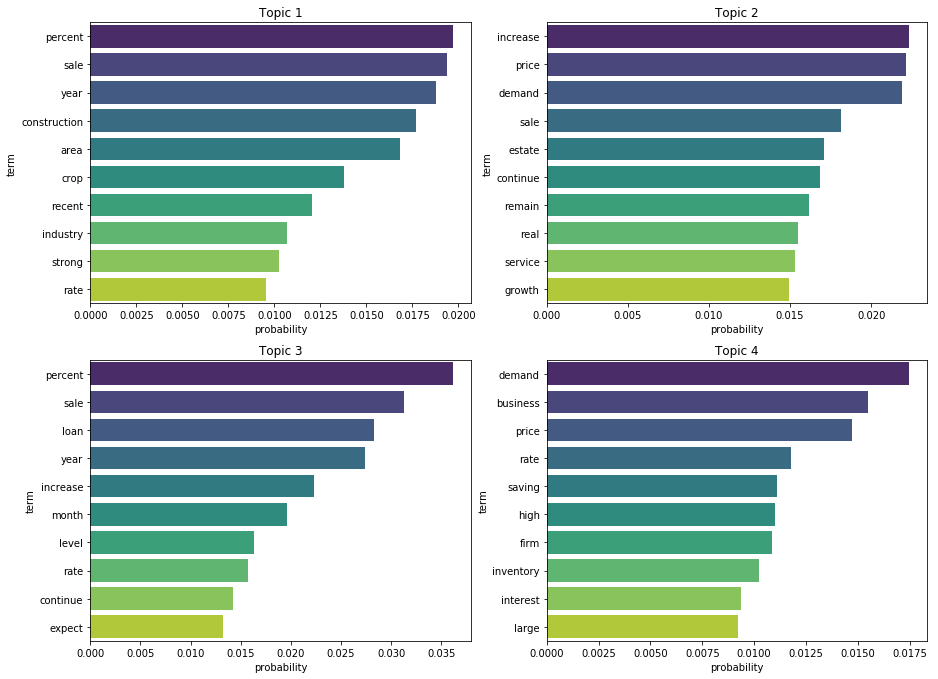

In [95]:
fiz=plt.figure(figsize=(15,30))
for i in range(4):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('Topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='viridis')
    plt.xlabel('probability')
    

plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

class HeirarchicalClusters(BaseEstimator, TransformerMixin):
    def __init__(self, k = 10):
        self.k = k
        self.distance = nltk.cluster.util.cosine_distance
        self.model = AgglomerativeClustering()
        
    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        clusters = self.model.fit_predict(documents)
        self.labels = self.model.labels_
        self.children = self.model.children_
        
        return clusters

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(children, **kwargs):
    distance = position = np.arange(children.shape[0])
    
    linkage_matrix = np.column_stack([children, distance, position]).astype(float)
    
    fig, ax = plt.subplots(figsize = (15, 7))
    ax = dendrogram(linkage_matrix, **kwargs)
    plt.tick_params(axis = 'x', bottom = False, top=False, labelbottom=False)
    plt.tight_layout()
    plt.title('Agglomerative Clustering of the Beige Book', fontsize = 20)
    plt.show()

children = hclusters.children

plot_dendrogram(children)